In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

In [10]:
# Global parameters

radius_range = np.arange(0.5,1.6,0.5)

with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)

point_collection_indices = np.arange(len(new_contiguous_point_collection))
point_collection_indices

array([0, 1, 2, 3, 4, 5, 6])

# Step 1 Getting sample points for one-time partial radius

Done generating 1000 samples in 0.123 seconds.


(array([153., 138., 141., 137., 136., 150., 145.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

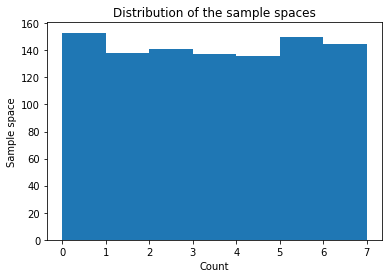

In [22]:
samples = 1000

sample_points = []

samples_indeces = []

t0 = time.time()

for i in np.arange(samples):

    random_object = np.random.choice(point_collection_indices)

    object_name = new_contiguous_point_collection[random_object][0]
    pointCloud = new_contiguous_point_collection[random_object][1]
    triangles = new_contiguous_point_collection[random_object][2]
    
    triangle_index = np.random.choice(np.arange(len(triangles)))
    vertex_index = triangles[triangle_index,1]
    original_vertex = pointCloud[vertex_index]

    sample_points.append([
        random_object, 
        object_name, 
        original_vertex
    ])
    
    samples_indeces.append(random_object)
    
print("Done generating",len(sample_points),"samples in {:.3f} seconds.".format(time.time()-t0))

with open('sample_points.pickle','wb') as f:
    pickle.dump(sample_points,f)
    
plt.title("Distribution of the sample spaces")
plt.xlabel("Count")
plt.ylabel("Sample space")
plt.hist(samples_indeces,bins = np.arange(0,8))


In [ ]:
        
def GetPartialPointCloudOptimizedNearby(
    pointCloud,
    triangles,
    radius = 1,
    vertex = [],
    verbose = False,
    extract = False,
    pointCloud_index = 0,
    nearby = False,
    nearby_threshold = 1.0
):

    t0 = time.time()
    triangle_indices = np.arange(len(triangles))
    
    if vertex == []:
        get_new_triangle = np.random.choice(triangle_indices)
    #rint("origin-triangle index",get_new_triangle,"(Remember, the triangle indices can be more than the point population.)")
        vertex = triangles[get_new_triangle,1]
        if verbose: print(" Computed origin-vertex",vertex)
    
    vertex = np.clip(vertex,0,len(pointCloud))

    if extract:
        nbrs = NearestNeighbors(n_neighbors=len(pointCloud)-1, algorithm='brute').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
    
    distances = extracted_nns[pointCloud_index][1]
    indices = extracted_nns[pointCloud_index][2]
    
    if nearby:    
        local_indexs =  indices[vertex,np.where(distances[vertex]<(radius*nearby_threshold))[0]]
        nearby_vertex = np.random.choice(local_indexs)
        vertex = nearby_vertex
        
    original_vertex = pointCloud[vertex]
    if verbose: print("   ",original_vertex[:3],vertex,pointCloud[vertex,:3])
    # makes sure that we don't get a point beyond the pC size
    # 1.b
    # list EVERYTHING, then update one-by-one

    #t1 = time.time()
    #print("  GetPartialPointCloud: Done getting nearest neighbors {:.3f} ".format(t1-t0))
    
    partial_pointcloud = []
    partial_triangles = []
    
    #while len(triangle_indices)>0:
    t0 = time.time()
    # Get a starting vertex
    

    # Get the acceptable neighbors of the chosen point
    acceptable_point_neighbors = indices[vertex,np.where(distances[vertex]<radius)[0]]
    depletable_triangles = np.copy(triangles)
    #print(len(acceptable_point_neighbors),"neighbors")
    acceptable_neighbor_distances = distances[vertex,np.where(distances[vertex]<radius)[0]]
    
    #t2 = time.time()
    #print("  GetPartialPointCloud: Done getting acceptable neighbors {:.3f} ".format(t2-t1))

    # While distance of points to be addded are less than 1,
    # get the indices of the connected items.
    prev_length = 0
    stopcount = 0

    # Get all triangles with the index in the neighbor list
    for v in acceptable_point_neighbors:    
        included_triangle_indices = np.concatenate((
            np.where(depletable_triangles[:,0]==v)[0],
            np.where(depletable_triangles[:,1]==v)[0],
            np.where(depletable_triangles[:,2]==v)[0]),0)

        local_triangles = depletable_triangles[np.unique(included_triangle_indices)]
        depletable_triangles = np.delete(depletable_triangles,np.unique(included_triangle_indices),0)

        if len(partial_triangles) > 0:
            partial_triangles = np.concatenate((partial_triangles,local_triangles),0)
            partial_triangles = np.asarray(partial_triangles)
        else:
            partial_triangles = local_triangles

    included_vertices = np.unique(partial_triangles.flatten('C'))
    index_list = []
    
    #t3 = time.time()
    #print("  GetPartialPointCloud: Done getting vertices {:.3f} ".format(t3 - t2))

    for in_vertex in included_vertices:
        if in_vertex in acceptable_point_neighbors:
            # before adding to the partial lists, check if in the acceptable neighbor list.

            partial_pointcloud.append(pointCloud[in_vertex])
            #depletable_neighbors = np.delete(depletable_neighbors,np.where(depletable_neighbors==in_vertex),0)
            index_list.append(in_vertex)
            np.place(partial_triangles,partial_triangles==in_vertex,len(partial_pointcloud)-1)
        else:
            # if not, remove associated triangles
            partial_triangles = np.delete(partial_triangles,np.unique(np.where(partial_triangles==in_vertex)[0]),0)

    #t4 = time.time()
    #print("  GetPartialPointCloud: Done getting triangles {:.3f} ".format(t4 - t3))
    
    partial_pointcloud = np.asarray(partial_pointcloud)
   
    return partial_pointcloud, partial_triangles, original_vertex, vertex

# Step 1: Compute the descriptors from the extracted point cloud

In [ ]:
descriptors = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
            
    t0 = time.time()
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(
            pointCloud,
            down_resolution = 5,
            cylindrical_quantization = [4,5]
        )
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name,"in",time.time()-t0,"seconds.")
    print(" ",pointCloud.shape,triangles.shape)
    print(" ",t_keypoints.shape,t_descriptors.shape)
        
    descriptors.append([
        object_name,
        t_descriptors,
        t_keypoints,
        t_d_c
    ])
    

In [ ]:
# Uncomment below if you want to overwrite the exisiting descriptors.

"""
    with open('descriptors/new_complete_res5_4by5_descriptors.pickle','wb') as f:
        pickle.dump(descriptors,f)
"""

# Step 2.1 Creating a synthetic set of partial spaces

In [ ]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = radius_range

# We used 100 for our investigation
samples = 50

In [ ]:
"""
NOTE!
There is a sample set of partial spaces in testing_samples/{}_partial_point_cloud.

You may run this to produce a new set with different parameters (as above).
If you wish to run it again, make sure you create the NNs from Step 0.1.

"""

for radius in radius_range:
    
    partial_point_collection = []
    
    t0 = time.time()
    
    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        partial_pointcloud, partial_triangles, original_vertex, _v = GetPartialPointCloudOptimizedNearby(
            np.asarray(pointCloud),
            np.asarray(triangles),
            radius,
            pointCloud_index=random_object
        )
        
        partial_point_collection.append([
            [random_object, object_name, original_vertex],
            partial_pointcloud,
            partial_triangles            
        ])
        
        with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(partial_point_collection,f)
            
        if i % 10 == (samples-1)%10:
            print("Done with {} samples for radius = {:.2f} in {:.3f} seconds".format(i,radius,time.time() - t0))
            t0 = time.time()

# Step 2.2 Creating a synthetic set of successive partial spaces


In [ ]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# For our work, we orignally used 50 samples with further 100 successive releases for our investigation.
# Below are lower parameters, change as desired.
samples = 50
releases = 50

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

In [ ]:
"""
NOTE!
There is a sample set of partial spaces in testing_samples/{}_successive_point_cloud.

You may run this to produce a new set with different parameters (as above).
If you wish to run it again, make sure you create the NNs from Step 0.1.

"""

t0 = time.time()

for radius in radius_range:
        
    successive_point_collection = []

    t1 = time.time()

    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        #growing_p_pointcloud = []

        growing_point_collection = []

        for release in np.arange(releases):

            if release == 0:
                # For first release, as usual.
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius,
                    pointCloud_index=random_object,
                    #verbose = True
                )
            else:

                # For succeeding release, get a nearby point vertex everytime from the previous vertex
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius = radius,
                    vertex = previous_v_i,
                    pointCloud_index=random_object,
                    nearby = True,
                    nearby_threshold=2.0
                    #verbose = True
                )
                
                #print("  Previous vertex",previous_vertex[:3],previous_v_i,pointCloud[previous_v_i,:3])
                #print("  New vertex",original_vertex[:3],v_i,pointCloud[v_i,:3])                
                
                if LA.norm(original_vertex[:3] - previous_vertex[:3]) >= 2.0*radius:
                    print("  Release: {} Warning: The distance of the succeeding vertices is {:.2f}"
                          .format(release,LA.norm(original_vertex[:3] - previous_vertex[:3]))
                         )
                    
            previous_v_i = v_i
            previous_vertex = original_vertex

            growing_point_collection.append([
                [random_object, object_name, original_vertex],
                partial_pointcloud,
                partial_triangles            
            ])

            if (release % int(releases/3) == 5) and (i % 7 == 2):
                print("  Done with {} releases of sample {} for radius = {:.2f} in {:.3f} seconds"
                      .format(release,i,radius,time.time() - t1))
                t1 = time.time()

        successive_point_collection.append([
            [random_object, object_name],
            growing_point_collection
        ])

        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_point_collection,f)

    print(" Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()


# Step 0: Extract the point cloud data from the OBJ files
 - store as numpy arrays

In [ ]:
# Getting the path to the Raw point clouds

OBJ_DIR = 'point_clouds/'

# Format is a tuple of (file path, file name).
OBJ_PATHS = [ [os.path.join(OBJ_DIR, f), f]
                    for f in os.listdir(OBJ_DIR) ]

OBJ_PATHS.remove(OBJ_PATHS[0]) # remove .DS Store file

# If we desire to treat the various objects within the OBJ as different spaces,
# we store it here.
new_per_object_collection = []

# If we desire to treat the entire OBJ as a space,
# we store it here.
new_per_space_collection = []

# This is to combine the objects within an OBJ to slightly larger objects. 
#Roughly 2.5m radius
combining_radius = 2.5

for path, filename in OBJ_PATHS:
    
    pointCloudFile = open(path)#'point_cloud.obj')('SpatialMesh.obj')#

    pointCloudLines = pointCloudFile.readlines()
    
    pointCollection = [] # object_number, vertices, vertex normals, polygons

    pointCollection_no_objects = [[],[],[]] 
    prev_length = 0
    vertices_length = 1
    
    for line in pointCloudLines:

        if line == '\n': continue

        line_items = line.split()

        if line_items[0] == 'o':
            object_item = line_items[1].split('.')
            object_number = int(object_item[-1])
            pointCollection.append([object_number, [], [], []])
            vertices_length += prev_length

            #print(object_number)

        if line_items[0] == 'v':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            if len(line_items)> 4:
                c = line_items[4]
                if float(c) > 0.85:
                    pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                    pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
            else:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z)])
            prev_length = len(pointCollection[object_number-1][1])


        if line_items[0] == 'vn':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            pointCollection[object_number-1][2].append([float(x),float(y),float(z)])
            pointCollection_no_objects[1].append([float(x),float(y),float(z)])

        if line_items[0] == 'f':
            p1 = int(line_items[1].split('//')[0])
            p2 = int(line_items[2].split('//')[0])
            p3 = int(line_items[3].split('//')[0])
            pointCollection[object_number-1][3].append([p1-vertices_length,
                                                        p2-vertices_length,
                                                        p3-vertices_length])
            pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

    pointCloudFile.close
    print(filename)
    #print(" Length of point collection",len(pointCollection[1][1]))
    print(" Total number of point collections",len(pointCollection))
    
    #Combining objects: 1. Getting centroids
    centroids = []

    for object_name, pointCloud, _vn, triangles in pointCollection:
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length
        normals = np.asarray(_vn)
        
        centroids.append([object_name,
              np.mean(pointCloud[:,0]), # x-axis
              np.mean(pointCloud[:,2]), # z-axis
             ])
        
    centroids = np.asarray(centroids)
    remaining_centroids = np.copy(centroids)
    
    combinedPointCollection = []
    count = 1
    
    while(remaining_centroids.size!=0):
        #print("  ",remaining_centroids[0,0],remaining_centroids.shape)
        #focusing on the first remaining collection, i.e. through its centroid
        collection = np.where(LA.norm(remaining_centroids[:,1:] - remaining_centroids[0,1:], axis = 1)<combining_radius)[0]
        
        #print("  ",collection)
        
        pointCloud = np.asarray(pointCollection[int(remaining_centroids[collection[0],0]-1)][1])
        normals = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][2])
        triangles = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][3])

        for index in collection[1:]:
            
            n_pointCloud = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][1])
            n_normals = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][2])
            n_triangles = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][3])+len(pointCloud)

            pointCloud = np.concatenate((pointCloud,n_pointCloud),0)
            normals = np.concatenate((normals,n_normals),0)
            triangles = np.concatenate((triangles,n_triangles),0)
        
        new_per_object_collection.append([
            filename+str(count),
            pointCloud,
            normals,
            triangles])
        
        combinedPointCollection.append([
            pointCloud,
            normals,
            triangles])
            
        count += 1
        remaining_centroids = np.delete(remaining_centroids,collection,axis=0)
        #print("   post",remaining_centroids.shape)
        
    print(" Resulting number =",len(combinedPointCollection))
#    new_per_object_collection.append([
#        filename,
#        combinedPointCollection
#    ])
    
    new_per_space_collection.append([
        filename,
        np.asarray(pointCollection_no_objects[0]),
        np.asarray(pointCollection_no_objects[1]),
        np.asarray(pointCollection_no_objects[2])
    ])

print(len(new_per_object_collection),"total objects.")
print(len(new_per_space_collection),"total spaces.")

In [ ]:
# Combining the point position information with their normal vectors.

new_contiguous_point_collection = []

for object_name, pointCloud, vn, triangles in new_per_space_collection:
    new_contiguous_point_collection.append([
        object_name, 
        np.concatenate((pointCloud,vn),axis = 1),
        triangles
    ])
    
sample_index = np.random.choice(len(new_contiguous_point_collection))
print("Sample:",
      new_contiguous_point_collection[sample_index][0],
      new_contiguous_point_collection[sample_index][1].shape, # shape of the point cloud array
      new_contiguous_point_collection[sample_index][2].shape # shape of the triangle array
     )

In [ ]:
# Uncomment below if you want to overwrite the exisiting point collection.

"""

with open('point_collection/new_contiguous_point_collection.pickle','wb') as f: 
    pickle.dump(new_contiguous_point_collection,f)

"""

In [ ]:
"""
fig=plt.figure()#figsize=(20, 14.5))

sample_name = new_contiguous_point_collection[sample_index][0]
sample_pointCloud = new_contiguous_point_collection[sample_index][1]
sample_triangles = new_contiguous_point_collection[sample_index][2]

print(sample_name,sample_pointCloud.shape,sample_triangles.shape)

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
#ax0.set_title('Dense Point Cloud')

X = sample_pointCloud[:,0]
Y = sample_pointCloud[:,1]
Z = sample_pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))

try:
    ax0.scatter(
        X,-Z,Y,
        alpha = 0.3
    )

    ax0.plot_trisurf(
        X, -Z, Y, 
        triangles=sample_triangles,
        cmap=plt.cm.Spectral
        #alpha = 0.5
    )

except Exception as ex:
    print(ex)
    pass

#plt.show()
"""